# Movie 1 - SWELL1 Distribution in migrating cell
## Load movie frames and perform segmentations

In [264]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

movie1_path = "movies/movie1.avi"

In [266]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0


def get_segment_gaps(right_segments, edge=0, side='left', fill_size=2, space_from_edge=0):
    gaps = []
    for i in range(1,len(right_segments)):
        px, py, pw, ph = right_segments[i-1]
        nx, ny, nw, nh = right_segments[i]
        
        gx = edge+space_from_edge if side=='left' else edge-fill_size-space_from_edge
        gy = (py+ph)-1 if py+ph<=ny else (ny+nh)-1
        gw = fill_size
        gh = ny-(py+ph)+2 if py+ph<=ny else py-(ny+nh) +2

        print("Gap:", (gx, gy, gw, gh))
        gaps.append((gx, gy, gw, gh))
    return gaps

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

outliers = []

## Calibrate and estimate parameters for segments

### Algorithm to find left and right edges
- Break the grayed frame into a contibuous sequence of rectangles of width 'check_size'.
- Calculate mean pixel values of each rectangle
- Return the first rectangle whose mean pixel value exceeds the threshold value 'min_mean_pixel'

### Applying the algorithm
- The appropriate width of each edge is set to 40 for this movie.
- Some correction values may also be used to include all pixels at edges

In [269]:
print("Press 'q' to end video")

cap = cv2.VideoCapture(movie1_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie1_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

data = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        isolated_cell = frame[35:90, :]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 14, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, imgThresh = cv2.threshold(gray_frame, 8, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        contours, hierarchy = cv2.findContours(imgThresh, 1, 2)
        contour = max(contours, key=cv2.contourArea)
        c_x,c_y,c_w,c_h = cv2.boundingRect(contour)
        left_end = c_x
        right_end = c_x+c_w

        left_section = gray_frame[:, c_x:c_x+30]
        left_blur = cv2.blur(left_section, (10,10))
        _,left_thresh = cv2.threshold(left_blur, 11, 255, cv2.THRESH_BINARY)

        right_section = gray_frame[:, c_x+c_w-30:c_x+c_w]
        right_blur = cv2.blur(right_section, (10,10))
        _,right_thresh = cv2.threshold(right_blur, 11, 255, cv2.THRESH_BINARY)

        imgThreshold[:, c_x:c_x+30] = left_thresh
        imgThreshold[:, c_x+c_w-30:c_x+c_w] = right_thresh

        # noise removal
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        bin_img = cv2.morphologyEx(imgThreshold, 
                                   cv2.MORPH_OPEN,
                                   kernel,
                                   iterations=2)
        
        sure_bg = cv2.dilate(bin_img, kernel, iterations=3)

        dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)

        ret, sure_fg = cv2.threshold(dist, 0.21 * dist.max(), 255, cv2.THRESH_BINARY)
        sure_fg = sure_fg.astype(np.uint8)

        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)
         
        # Add one to all labels so that background is not 0, but 1
        markers += 1
        # mark the region of unknown with zero
        markers[unknown == 255] = 0

        # create watershed markers
        markers = cv2.watershed(canvas, markers)

        labels = np.unique(markers)
        right_segments = []
        
        for label in labels[2:]:
            # Create a binary image in which only the area of the label is in the foreground 
            #and the rest of the image is in the background   
            target = np.where(markers == label, 255, 0).astype(np.uint8)
            x,y,w,h = cv2.boundingRect(target)
        
            #print("Distance from left edge:", label, " - ", x-left_end)
            #print("Distance from right edge:", label, " - ", right_end-x)
        
            color = (255, 255, 255)
            if x-left_end <= 13:
                count, mean = get_mean_intensity(canvas[markers == label])
                data.append([frame_index, "L", count, mean])
                
                
                canvas[markers == label] = [255,0,0]
                cv2.putText(canvas, "L", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
            elif right_end-(w+x) <= 13:
                count, mean = get_mean_intensity(canvas[markers == label])
                data.append([frame_index,"R", count, mean])
                
                canvas[markers == label] = [255,255,0]
                cv2.putText(canvas, "R", (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #right_rect = cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,0,255),1)
                right_segments.append((x,y,w,h))
            else:
                rand_color = [0,0,255]
                canvas[markers == label] = rand_color

        rect = cv2.rectangle(canvas, (c_x,c_y), (c_x+c_w,c_y+c_h), color, 1)
        writer.write(canvas)
        cv2.imshow("Movie 1", canvas)

    # 1 frame per second
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Clean data
- Convert data list to dataframe
- Convert edges to 0 and 1 values (0 for right edge and 1 for left edge)

In [272]:
data_df = pd.DataFrame(data, columns =  ["Frame", "Edge", "Intensity Count","Mean Intensity"])
dummies = pd.get_dummies(data_df)
data_with_dummies_df = pd.concat([data_df, dummies[["Edge_L"]]], axis='columns')
cleaned_data = data_with_dummies_df.drop(['Edge'], axis='columns')*1
cleaned_data.head()

,Frame,Intensity Count,Mean Intensity,Edge_L
0,1,1635,27.255046,1
1,1,677,17.550960,0
2,2,887,20.285231,0
3,2,1570,29.731210,1
4,3,1307,35.107116,1


## Exploratory Analysis

<Axes: >

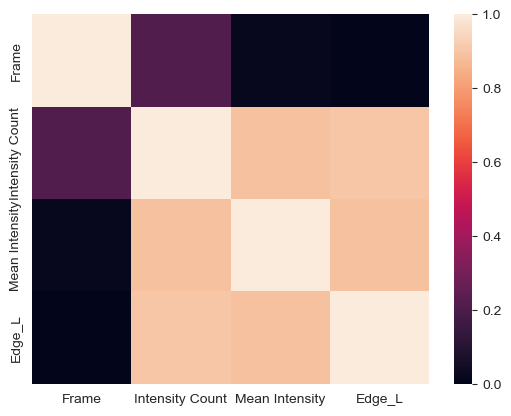

In [275]:
# Correlation
sns.heatmap(cleaned_data.corr())

- Strong correlation between Edge_L and Intensity Count (number of fluorescent pixels)
- Edge_L also correlates strongly with Mean Intensity (Mean fluorescent intensity)

Text(0.5, 0.98, 'Plot Fluorescence at Left (1) and Right (0) edges')

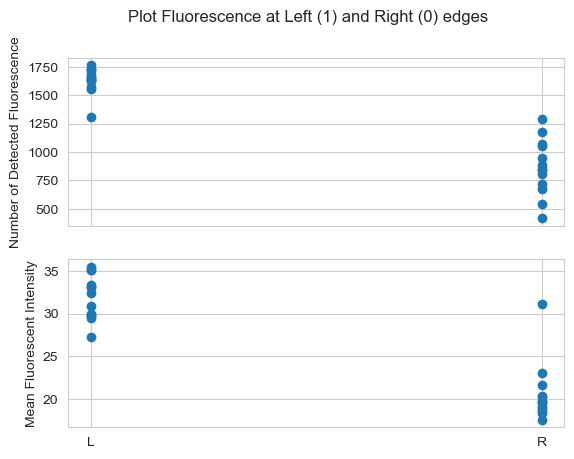

In [278]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
x = data_df["Edge"]
y1 = cleaned_data["Intensity Count"]
y2 = cleaned_data["Mean Intensity"]

ax1.scatter(x, y1)
ax2.scatter(x, y2)
 
ax1.set_ylabel('Number of Detected Fluorescence')
ax2.set_ylabel('Mean Fluorescent Intensity')
 
fig.suptitle('Plot Fluorescence at Left (1) and Right (0) edges')

- Different distribution of fluorescence at both edges
- Potential outlier at the Right edge (0)

<Axes: xlabel='Edge', ylabel='Mean Intensity'>

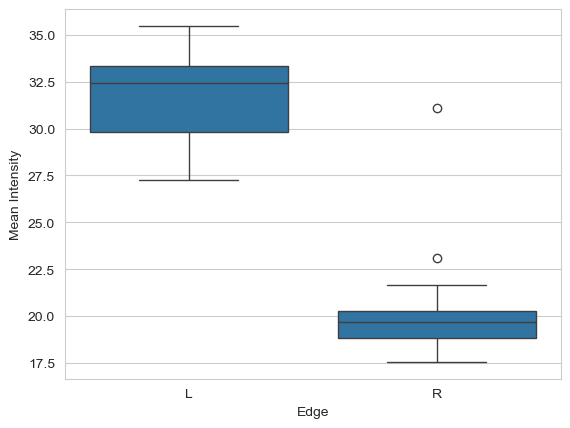

In [281]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'Edge', y = 'Mean Intensity', data = data_df)

- 2 outliers on right edge

<Axes: xlabel='Edge', ylabel='Intensity Count'>

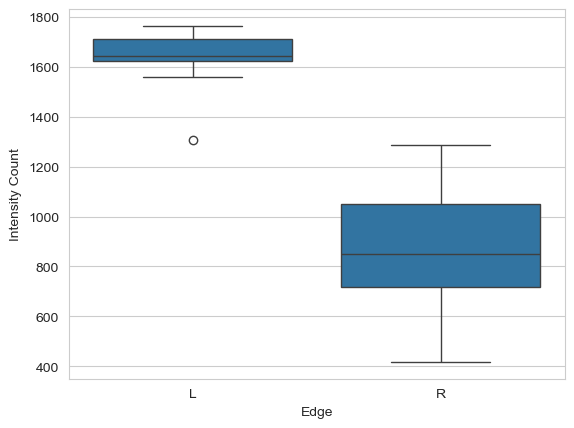

In [284]:
sns.boxplot(x = 'Edge', y = 'Intensity Count', data = data_df)

- 1 outlier on left edge

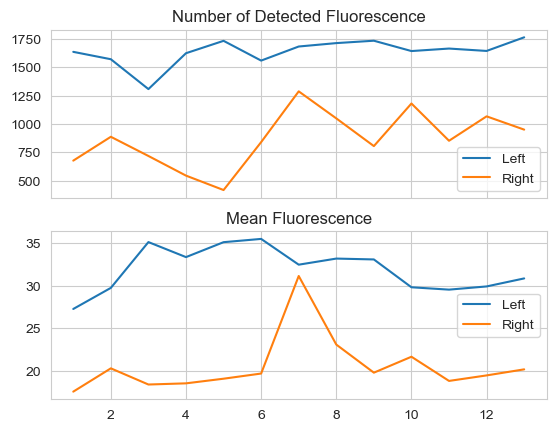

In [287]:
# Compare counts and intensities
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

left_edge_data = data_df[data_df["Edge"] == "L"]
right_edge_data = data_df[data_df["Edge"] == "R"]

X = left_edge_data["Frame"]
Y1 = left_edge_data["Intensity Count"]
Y2 = right_edge_data["Intensity Count"]

Y3 = left_edge_data["Mean Intensity"]
Y4 = right_edge_data["Mean Intensity"]

ax1.plot(X, Y1)
ax1.plot(X, Y2)
ax1.set_title("Number of Detected Fluorescence")

ax2.plot(X, Y3)
ax2.plot(X, Y4)
ax2.set_title("Mean Fluorescence")

ax1.legend(["Left","Right"],loc='best') 
ax2.legend(["Left","Right"],loc='best')

plt.savefig("movie1_fluorescence_line_plot.png")
plt.show()

#### Investigate outliers

##### Outliers for Number of Detected Fluorescence

In [291]:
## Left edge
Q3 = np.quantile(left_edge_data["Intensity Count"], 0.75)
Q1 = np.quantile(left_edge_data["Intensity Count"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
left_count_outliers = left_edge_data[(left_edge_data["Intensity Count"] < lower_range) | (left_edge_data["Intensity Count"] > upper_range)]
outliers = list(set(outliers + list(left_count_outliers["Frame"])))
outliers.sort()

In [293]:
## Right edge
Q3 = np.quantile(right_edge_data["Intensity Count"], 0.75)
Q1 = np.quantile(right_edge_data["Intensity Count"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
right_count_outliers = right_edge_data[(right_edge_data["Intensity Count"] < lower_range) | (right_edge_data["Intensity Count"] > upper_range)]
outliers = list(set(outliers + list(right_count_outliers["Frame"])))
outliers.sort()

In [295]:
outliers

[3]

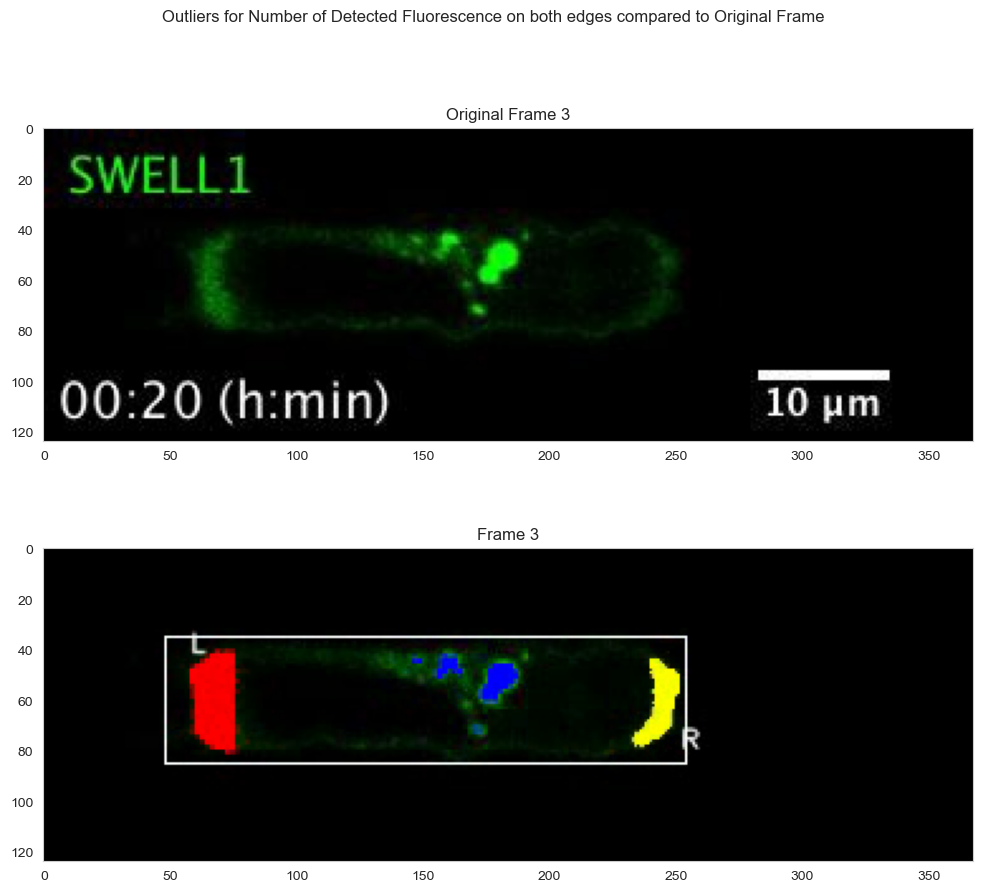

In [297]:
fig, (axes1, axes2) = plt.subplots(2, len(outliers), sharex=False, sharey=False, figsize=(12, 10))

video_name = "movie1_segments.avi"
cap = cv2.VideoCapture(video_name)

if len(outliers) > 1:
    for i in range(0, len(outliers)):
        frame = cv2.imread(f"movies/movie1/{outliers[i]}.jpg")
        axes1[i].grid(False)
        axes1[i].imshow(frame)
        axes1[i].set_title(f'Original Frame {outliers[i]}')
elif len(outliers) == 1:
    frame = cv2.imread(f"movies/movie1/{outliers[0]}.jpg")
    axes1.grid(False)
    axes1.imshow(frame)
    axes1.set_title(f'Original Frame {outliers[0]}')
    
if len(outliers) > 1:
    for i in range(0, len(outliers)):
        cap.set(1,outliers[i]-1)
        ret, frame = cap.read()
        axes2[i].grid(False)
        axes2[i].imshow(frame)
        axes2[i].set_title(f'Frame {outliers[i]}')
        
elif len(outliers) == 1:
    cap.set(1,outliers[0]-1)
    ret, frame = cap.read()
    axes2.grid(False)
    axes2.imshow(frame)
    axes2.set_title(f'Frame {outliers[0]}')
        
cap.release()
plt.suptitle("Outliers for Number of Detected Fluorescence on both edges compared to Original Frame")
plt.savefig("movie1_outlier_on_frame3.png")
plt.show()

##### Left Edge outlier on Frame 3 falls below the lower range
- Mean fluorescence intensity on Frame 3 not affected by the outlier

In [300]:
data_df[data_df["Frame"].isin(outliers)][data_df["Edge"]=="L"]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16352\2960880092.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_df[data_df["Frame"].isin(outliers)][data_df["Edge"]=="L"]


,Frame,Edge,Intensity Count,Mean Intensity
4,3,L,1307,35.107116


In [302]:
# Reset outliers
outliers = []

##### Outliers for Mean Fluorescent Intensity

In [305]:
## Left edge
Q3 = np.quantile(left_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(left_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
left_mean_outliers = left_edge_data[(left_edge_data["Mean Intensity"] < lower_range) | (left_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(left_mean_outliers["Frame"])))
outliers.sort()

In [307]:
## Right edge
Q3 = np.quantile(right_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(right_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
right_mean_outliers = right_edge_data[(right_edge_data["Mean Intensity"] < lower_range) | (right_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(right_mean_outliers["Frame"])))
outliers.sort()

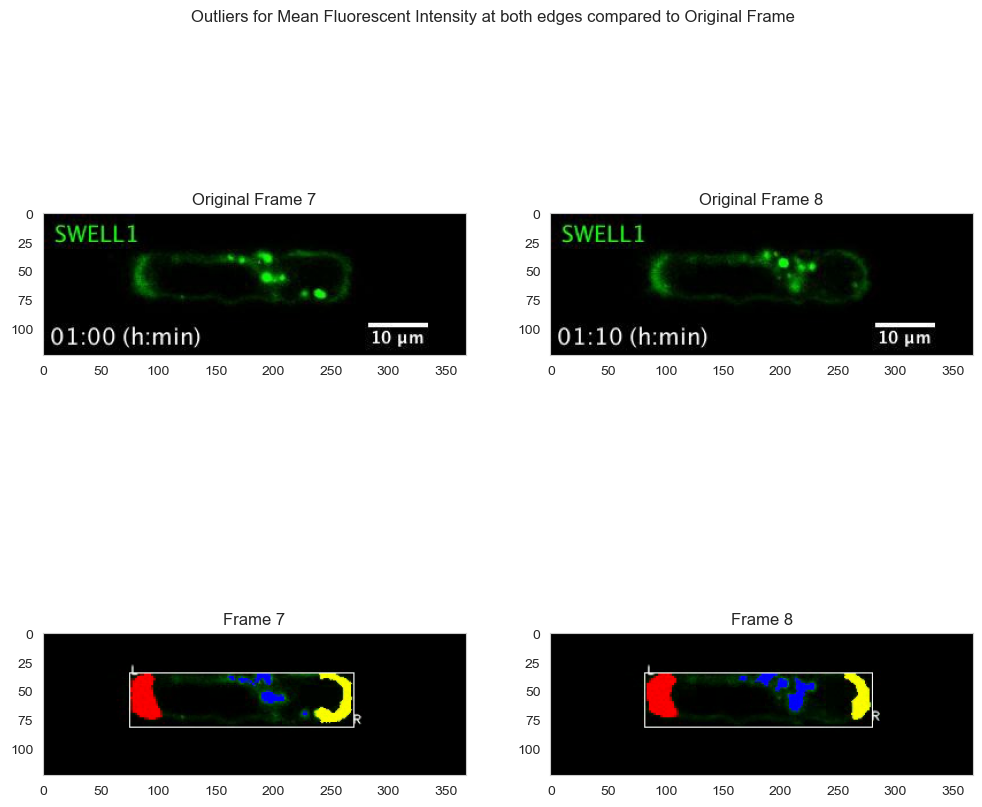

In [309]:
fig, (axes1, axes2) = plt.subplots(2, len(outliers), sharex=False, sharey=False, figsize=(12, 10))

video_name = "movie1_segments.avi"
cap = cv2.VideoCapture(video_name)

if len(outliers) > 1:
    for i in range(0, len(outliers)):
        frame = cv2.imread(f"movies/movie1/{outliers[i]}.jpg")
        axes1[i].grid(False)
        axes1[i].imshow(frame)
        axes1[i].set_title(f'Original Frame {outliers[i]}')
elif len(outliers) == 1:
    frame = cv2.imread(f"movies/movie1/{outliers[0]}.jpg")
    axes1.grid(False)
    axes1.imshow(frame)
    axes1.set_title(f'Original Frame {outliers[0]}')
    
if len(outliers) > 1:
    for i in range(0, len(outliers)):
        cap.set(1,outliers[i]-1)
        ret, frame = cap.read()
        axes2[i].grid(False)
        axes2[i].imshow(frame)
        axes2[i].set_title(f'Frame {outliers[i]}')
        
elif len(outliers) == 1:
    cap.set(1,outliers[0]-1)
    ret, frame = cap.read()
    axes2.grid(False)
    axes2.imshow(frame)
    axes2.set_title(f'Frame {outliers[0]}')
        
cap.release()
plt.suptitle("Outliers for Mean Fluorescent Intensity at both edges compared to Original Frame")
plt.savefig("movie1_outlier_on_frame7-8.png")
plt.show()

In [311]:
data_df[data_df["Frame"].isin(outliers)]

,Frame,Edge,Intensity Count,Mean Intensity
12,7,L,1682,32.454816
13,7,R,1287,31.125874
14,8,L,1712,33.170561
15,8,R,1049,23.075310


##### Right Edge outliers on Frame 7 and 8 fall above the upper range range
- On Frame 7, high intensity fluorescence moved too close to the edge affecting the mean intensity
- On Frame 8, most of the high intensity fluorescence from Frame 7 move away from edge. Mean intensity is still slightly higher than the upper range

## Analysis of Variance between Left Edge and Right Edge Fluorescence
- Test to see if the observed difference in fluorescence are statistically significant
- Effect of outliers on test

##### With Outliers

In [316]:
import scipy.stats as stats
stats.f_oneway(left_edge_data["Intensity Count"], right_edge_data["Intensity Count"])

F_onewayResult(statistic=104.01090316754409, pvalue=3.343400305158689e-10)

- ANOVA test finds enough evidence for statistical difference between the mean Number of detected fluorescence at the Left (Trailing) edge and that at the Right (Leading) edge
- F-statistic = 104.011
- P-value = 3.43e-10

In [319]:
stats.f_oneway(left_edge_data["Mean Intensity"], right_edge_data["Mean Intensity"])

F_onewayResult(statistic=88.79955385375098, pvalue=1.5477284960305622e-09)

- ANOVA test finds enough evidence for statistical difference between the means of Mean FLuorescent Intensity at Trailing and Leading edges
- F-statistic = 88.80
- P-value = 1.55e-9

##### Without outliers

In [323]:
# Remove frame 3
left_edge_no_frame3 = left_edge_data[(left_edge_data['Frame']<3) | (left_edge_data['Frame']>3)]
right_edge_no_frame3 = right_edge_data[(right_edge_data['Frame']<3) | (right_edge_data['Frame']>3)]

In [325]:
stats.f_oneway(left_edge_no_frame3["Intensity Count"], right_edge_no_frame3["Intensity Count"])

F_onewayResult(statistic=108.81717357926739, pvalue=5.565768767797297e-10)

- ANOVA test without outliers finds enough evidence for statistical difference between the mean Number of detected fluorescence at the Left (Trailing) edge and that at the Right (Leading) edge
- F-statistic = 108.817
- P-value = 5.566e-10

In [328]:
right_edge_no_frame78 = right_edge_data[(right_edge_data['Frame']<7) | (right_edge_data['Frame']>8)]
left_edge_no_frame78 = left_edge_data[(left_edge_data['Frame']<7) | (left_edge_data['Frame']>8)]

In [330]:
stats.f_oneway(right_edge_no_frame78["Mean Intensity"], left_edge_no_frame78["Mean Intensity"])

F_onewayResult(statistic=185.78240052639939, pvalue=1.3877650187526855e-11)

- ANOVA test finds enough evidence for statistical difference between the means of Mean FLuorescent Intensity at Trailing and Leading edges
- F-statistic = 185.782
- P-value = 1.388e-11